# Week 2

## Loading the data

### Download repository

In [1]:
import matplotlib
%matplotlib inline

### Load data from repository

In [2]:
import pandas as pd
df = pd.read_csv('grocery_training_data.csv')
df.head()

,n_bananas,n_apples,n_oranges,n_chocolate,n_kombucha,total_price
0,3,6,3,0,9,49.506000
1,7,7,9,6,7,71.853870
2,9,0,1,9,2,32.135744
3,8,0,1,6,1,21.994054
4,9,1,5,9,4,47.286625


Now, transform your data into numpy array

In [3]:
# Columns: n_bananas,	n_apples,	n_oranges,	n_chocolate,	n_kombucha,	total_price
data = df.reset_index().values

This seems a bit overkill since we have 5 unknows and many equations. I guess here the least-squares approach would be better here.

In [4]:
import numpy as np
tot_price = data[:,-1]
G = data[:,1:-1]
G_inv = np.dot(np.linalg.inv(np.dot(G.T,G)),G.T)

In [5]:
prices = np.dot(G_inv, tot_price)
objects = ['bananas',	'apples',	'oranges',	'chocolate', 'kombucha']

print("Prices:")
for price,obj in zip(prices, objects):
  print(obj+":", "%3.2f" % price)

Prices:
bananas: 0.50
apples: 2.85
oranges: 1.63
chocolate: 2.25
kombucha: 2.89


After a first least squares approach, let's see whether a single Neuron can find the same values.

## Single Perceptron

1. initialize a random set of weights (or prices) and create your neuron's estimate for the grocery bill total (the weighted sum).

2. You can then compare this estimated total to the actual total, which is given to you, with the cost function (see blog post)

3. Then, use the analytical gradients for cost with respect to each weight to update the weights.

4. With your new weights, go through the whole process again of estimation, cost calculation, and weight update. Do this until your weights seem to settle on "steady" values, which now represent the cost of each item!

### 1. Initialize Weights

In [6]:
# Random Weights (prizes)
np.random.seed(123456)
w = 10*np.random.rand(5)
print(w)


[1.26969833 9.66717838 2.60476006 8.97236524 3.76749716]


Now, we compute the cost function

$$ \begin{array}{l}{C=\frac{1}{2}(y-\hat{y})^{2}} \\ {C=\frac{1}{2}\left(y-w_{1} x_{1}-w_{2} x_{2}\right)^{2}}\end{array}$$


In [7]:
y = tot_price
y_hat = np.dot(G,w)

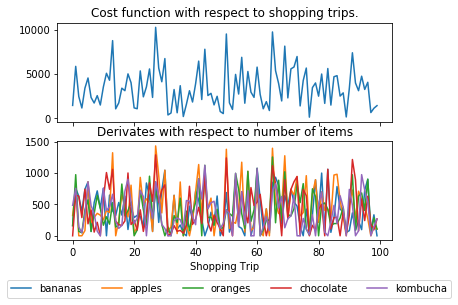

In [8]:
import matplotlib.pyplot as plt

res = (y - y_hat)
C = .5 * (res)**2
dCdw = -G*dC[:,np.newaxis]

fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(C)
ax[0].set_title('Cost function with respect to shopping trips.')

ax[1].plot(dCdw)
ax[1].set_title('Derivates with respect to number of items')
ax[1].set_xlabel('Shopping Trip')
ax[1].legend(objects, bbox_to_anchor=(-0.15,-0.6,1,0.2), ncol=5, loc="upper left",borderaxespad=0)
plt.show()

### Learning rate
The next step is to iteratively update the weights/prices 
using gradient descent. First I'm gonna write down the
the function that does the cool things.

In [9]:
def nn_batch(X,w,y,lr,n_epoch, single_updates=False):
  """Simple single perceptron Convolutional neural network
  
  Args:
    X: matrix such that X*w = y
    w: vector
    y: vector
    lr: learning rate
    n_epoch: number of training epochs
    single_updates: updates the weight using each 
                    data point individually if set to True
                    Default is False.
  
  Returns:
    w_list: list of weights over epochs
    cost_list: List of cost reduction over epochs
  """
  
  # List to collect the cost and weights of each epoch
  w_list = []
  cost_list = []
  
  # First approximation (weights could be zero?)
  y_hat = np.dot(X,w)

  # Compute first cos
  residual = y - y_hat
  cost = 0.5*np.sum((residual)**2)
  cost_list.append(cost)
  w_list.append(w)

  # Iterate over epoch
  for epoch in range(n_epoch):

    if single_updates:
      # Update the weights in each epoch for each 
      # data points
      for _i, itemNs in enumerate(X):
        # Get dependent residual
        dCdw = -itemNs*residual[_i]

        # Update the weights
        w = w - lr * dCdw
        w_list.append(w)

        # Compute new iteration of the synthetic data
        y_hat = np.dot(X,w)

        # Update Cost and residual
        residual = y - y_hat
        cost = 0.5*np.sum((residual)**2)
        cost_list.append(cost)

    else:
      # Compute the gradient 
      dCdw = np.dot(-X.T, residual)

      # Update the weights
      w = w - lr * dCdw
      w_list.append(w)

      # Compute new iteration of the synthetic data
      y_hat = np.dot(X,w)

      # Update Cost and residual
      residual = y - y_hat
      cost = 0.5*np.sum((residual)**2)
      cost_list.append(cost)

    # Print status
    if epoch%20 ==0:
            print("Epoch: {:d} -- Cost: {:f} w: [{:f},{:f},{:f},{:f},{:f}] ".format(epoch,cost,w[0],w[1],w[2],w[3],w[4]))
    
    # End loop if cost is below threshold
    if cost <= 0.0001:
            break

  return w_list, cost_list


In [10]:
# One single data point
lr = 0.0001
n_epoch = 501
np.random.seed(123457)
subset = 50
offset = 20
w_list, cost_list = nn_batch(G[offset:subset+offset,:],  # The grocery counts matrix
                             5*np.random.rand(5), # The initial prices
                             y[offset:subset+offset], # The total prices
                             lr,n_epoch, single_updates=False)
          

Epoch: 0 -- Cost: 3478.834079 w: [2.269456,0.382413,2.673539,3.572922,1.100874] 
Epoch: 20 -- Cost: 542.677129 w: [1.310708,1.776406,2.521650,2.495788,2.171478] 
Epoch: 40 -- Cost: 131.909595 w: [0.887605,2.311224,2.202603,2.225237,2.556191] 
Epoch: 60 -- Cost: 39.026370 w: [0.698951,2.563932,1.973582,2.187996,2.724317] 
Epoch: 80 -- Cost: 12.337364 w: [0.606173,2.693916,1.830011,2.201045,2.803616] 
Epoch: 100 -- Cost: 3.975598 w: [0.557269,2.764319,1.744719,2.218647,2.843344] 
Epoch: 120 -- Cost: 1.288127 w: [0.530380,2.803525,1.695258,2.231752,2.864125] 
Epoch: 140 -- Cost: 0.418068 w: [0.515251,2.825663,1.666897,2.240177,2.875312] 
Epoch: 160 -- Cost: 0.135769 w: [0.506639,2.838244,1.650719,2.245289,2.881447] 
Epoch: 180 -- Cost: 0.044103 w: [0.501710,2.845413,1.641512,2.248309,2.884853] 
Epoch: 200 -- Cost: 0.014329 w: [0.498884,2.849504,1.636277,2.250068,2.886757] 
Epoch: 220 -- Cost: 0.004656 w: [0.497262,2.851838,1.633301,2.251086,2.887827] 
Epoch: 240 -- Cost: 0.001513 w: [0.49

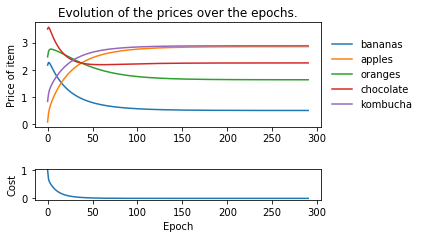

In [11]:
from matplotlib.pyplot import GridSpec

def plot_cost_and_weights(w_list, cost_list, objects):
  fig = plt.figure()
  spec = GridSpec(ncols=1, nrows=4, figure=fig)
    
  # Plot evolution of the weights
  ax0 = fig.add_subplot(spec[0:2,:])
  ax0.set_ylabel("Price of item")
  ax0.plot(w_list)
  ax0.set_title("Evolution of the prices over the epochs.")
  ax0.legend(objects, bbox_to_anchor=(1.025,0.5), ncol=1,
            loc="center left",borderaxespad=0, fancybox=False,
            frameon=False)

  # Plot the evolution of cost function
  ax1 = fig.add_subplot(spec[2,:])
  ax1.plot(cost_list/np.max(cost_list))
  ax1.set_ylabel("Cost")
  ax1.set_xlabel("Epoch")
  plt.tight_layout()
  plt.show()

plot_cost_and_weights(w_list, cost_list, objects)

In the above case, the entire residual for each epoch is considered.
Meaning, during each epoch we compute the residual between observed and
modeled data, and afterwards we compute the gradient of the cost function
(which contains all residuals) with respect to each weight. Then, we define
a learning rate as a descent step, and update the weights as

$$\mathbf{w}_{i+1} = \mathbf{w}_{i} + \Delta \frac{dC}{d\mathbf{w}},$$

where $\Delta$ is the learning rate/gradient descent fraction step.

As opposed to considering all residuals to update the weights, we can also
update the weights iteratively by considereing the residual for one 
grocery trip at a time. In that case, we update the weights in a similar
fashion as shown in the equation above. The difference is that in each epoch,
we update the weights using each individual residual. This means that in every
epoch, the weights are updated the number of data points you have.

In practice, I added a flag to the function we used earlier to consider the
full residuals, which when turned on will compute the weights constantly.

Epoch: 0 -- Cost: 93.057422 w: [0.692492,2.662644,2.006704,1.945490,2.592555] 


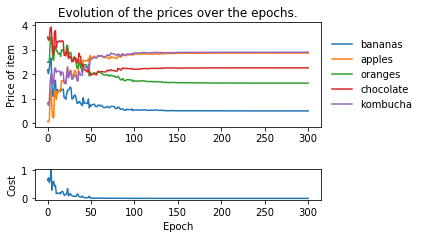

In [12]:

lr = 0.005
n_epoch = 101
np.random.seed(123457)
subset = 50
offset = 20
w_list, cost_list = nn_batch(G[offset:subset+offset,:],  # The grocery counts matrix
                             5*np.random.rand(5), # The initial prices
                             y[offset:subset+offset], # The total prices
                             lr,n_epoch, single_updates=True)

plot_cost_and_weights(w_list, cost_list, objects)